<a href="https://colab.research.google.com/github/RoshiniBanu21/IBM-Project-7508-1658884203/blob/master/3-5-13-PretrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate the Pretrained Model
This notebook uses the pre-trained [micro_speech](https://github.com/tensorflow/tensorflow/tree/v2.4.1/tensorflow/lite/micro/examples/micro_speech) example for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview) 20 kB [Simple Audio Recognition](https://www.tensorflow.org/tutorials/sequences/audio_recognition) model to recognize keywords! **We strongly suggest you take your time working through this file to start to understand the code as we will be using a very similar file to train the model with your choice of keywords during the assignment.**

### Import packages
Clone the TensorFlow Github Repository, which contains the relevant code required to run this tutorial. And import the old version of TF1 for backwards compatibility.

In [41]:
!wget https://github.com/tensorflow/tensorflow/archive/v2.14.0.zip
!unzip v2.14.0.zip &> 0
!mv tensorflow-2.14.0/ tensorflow/

--2025-01-28 13:48:07--  https://github.com/tensorflow/tensorflow/archive/v2.14.0.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tensorflow/tensorflow/zip/refs/tags/v2.14.0 [following]
--2025-01-28 13:48:07--  https://codeload.github.com/tensorflow/tensorflow/zip/refs/tags/v2.14.0
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v2.14.0.zip.1’

v2.14.0.zip.1           [        <=>         ]  89.27M  12.1MB/s    in 8.5s    

2025-01-28 13:48:16 (10.5 MB/s) - ‘v2.14.0.zip.1’ saved [93606267]



In [42]:
import tensorflow.compat.v1 as tf
import sys
# We add this path so we can import the speech processing modules.
sys.path.append("/content/tensorflow/tensorflow/examples/speech_commands/")
import input_data
import models
import numpy as np
import pickle

### Configure Defaults
In this Colab we will just run with the default configurations to use the pre-trained model. However, in your assignment you will try the model to recognize a new word.

In [43]:
# A comma-delimited list of the words you want to train for.
# All the other words you do not select will be used to train
# an "unknown" label so that the model does not just recognize
# speech but your specific words. Audio data with no spoken
# words will be used to train a "silence" label.
WANTED_WORDS = "yes,no"

# Print the configuration to confirm it
print("Spotting these words: %s" % WANTED_WORDS)

Spotting these words: yes,no


**DO NOT MODIFY** the following constants as they include filepaths used in this notebook and data that is shared during training and inference.

In [44]:
# Calculate the percentage of 'silence' and 'unknown' training samples required
# to ensure that we have equal number of samples for each label.
number_of_labels = WANTED_WORDS.count(',') + 1
number_of_total_labels = number_of_labels + 2 # for 'silence' and 'unknown' label
equal_percentage_of_training_samples = int(100.0/(number_of_total_labels))
SILENT_PERCENTAGE = equal_percentage_of_training_samples
UNKNOWN_PERCENTAGE = equal_percentage_of_training_samples

# Constants which are shared during training and inference
PREPROCESS = 'micro'
WINDOW_STRIDE = 20
MODEL_ARCHITECTURE = 'tiny_conv'

# Constants for training directories and filepaths
DATASET_DIR =  'dataset/'
LOGS_DIR = 'logs/'
TRAIN_DIR = 'train/' # for training checkpoints and other files.

# Constants for inference directories and filepaths
import os
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
MODEL_TF = os.path.join(MODELS_DIR, 'model.pb')
MODEL_TFLITE = os.path.join(MODELS_DIR, 'model.tflite')
FLOAT_MODEL_TFLITE = os.path.join(MODELS_DIR, 'float_model.tflite')
MODEL_TFLITE_MICRO = os.path.join(MODELS_DIR, 'model.cc')
SAVED_MODEL = os.path.join(MODELS_DIR, 'saved_model')

# Constants for Quantization
QUANT_INPUT_MIN = 0.0
QUANT_INPUT_MAX = 26.0
QUANT_INPUT_RANGE = QUANT_INPUT_MAX - QUANT_INPUT_MIN

# Constants for audio process during Quantization and Evaluation
SAMPLE_RATE = 16000
CLIP_DURATION_MS = 1000
WINDOW_SIZE_MS = 30.0
FEATURE_BIN_COUNT = 40
BACKGROUND_FREQUENCY = 0.8
BACKGROUND_VOLUME_RANGE = 0.1
TIME_SHIFT_MS = 100.0

# URL for the dataset and train/val/test split
DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
VALIDATION_PERCENTAGE = 10
TESTING_PERCENTAGE = 10

### Loading the pre-trained model

These commands will download a pre-trained model checkpoint file (the output from training) that we can use to build a model.

In [45]:
!curl -O "https://storage.googleapis.com/download.tensorflow.org/models/tflite/speech_micro_train_2020_05_10.tgz"
!tar xzf speech_micro_train_2020_05_10.tgz
TOTAL_STEPS = 15000 # used to identify which checkpoint file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  375k  100  375k    0     0  3389k      0 --:--:-- --:--:-- --:--:-- 3417k


### Generate a TensorFlow Model for Inference

Combine relevant training results (graph, weights, etc) into a single file for inference. This process is known as freezing a model and the resulting model is known as a frozen model/graph, as it cannot be further re-trained after this process.

In [46]:
!rm -rf {SAVED_MODEL}
!python tensorflow/tensorflow/examples/speech_commands/freeze.py \
--wanted_words=$WANTED_WORDS \
--window_stride_ms=$WINDOW_STRIDE \
--preprocess=$PREPROCESS \
--model_architecture=$MODEL_ARCHITECTURE \
--start_checkpoint=$TRAIN_DIR$MODEL_ARCHITECTURE'.ckpt-'{TOTAL_STEPS} \
--save_format=saved_model \
--output_file={SAVED_MODEL}

2025-01-28 13:48:43.128249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 13:48:43.146227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 13:48:43.152281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 13:48:44.446084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1738072126.224633   12519 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

### Generate a TensorFlow Lite Model

Convert the frozen graph into a TensorFlow Lite model, which is fully quantized for use with embedded devices.

The following cell will also print the model size, which will be under 20 kilobytes.

We download the dataset to use as a representative dataset for more thoughtful post training quantization.

**Note: this may take a little time as it is a relatively large file**

In [10]:
model_settings = models.prepare_model_settings(
    len(input_data.prepare_words_list(WANTED_WORDS.split(','))),
    SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
    WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS)
audio_processor = input_data.AudioProcessor(
    DATA_URL, DATASET_DIR,
    SILENT_PERCENTAGE, UNKNOWN_PERCENTAGE,
    WANTED_WORDS.split(','), VALIDATION_PERCENTAGE,
    TESTING_PERCENTAGE, model_settings, LOGS_DIR)

>> Downloading speech_commands_v0.02.tar.gz 100.0%


In [47]:
with tf.Session() as sess:
# with tf.compat.v1.Session() as sess: #replaces the above line for use with TF2.x
  float_converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
  float_tflite_model = float_converter.convert()
  float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)
  print("Float model is %d bytes" % float_tflite_model_size)

  converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.inference_input_type = tf.lite.constants.INT8
  # converter.inference_input_type = tf.compat.v1.lite.constants.INT8 #replaces the above line for use with TF2.x
  converter.inference_output_type = tf.lite.constants.INT8
  # converter.inference_output_type = tf.compat.v1.lite.constants.INT8 #replaces the above line for use with TF2.x
  def representative_dataset_gen():
    for i in range(100):
      data, _ = audio_processor.get_data(1, i*1, model_settings,
                                         BACKGROUND_FREQUENCY,
                                         BACKGROUND_VOLUME_RANGE,
                                         TIME_SHIFT_MS,
                                         'testing',
                                         sess)
      flattened_data = np.array(data.flatten(), dtype=np.float32).reshape(1, 1960)
      yield [flattened_data]
  converter.representative_dataset = representative_dataset_gen
  tflite_model = converter.convert()
  tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
  print("Quantized model is %d bytes" % tflite_model_size)


Float model is 68392 bytes
Quantized model is 19160 bytes


### Testing the accuracy after Quantization

Verify that the model we've exported is still accurate, using the TF Lite Python API and our test set.

In [48]:
# Helper function to run inference
def run_tflite_inference_testSet(tflite_model_path, model_type="Float"):
  #
  # Load test data
  #
  np.random.seed(0) # set random seed for reproducible test results.
  with tf.Session() as sess:
  # with tf.compat.v1.Session() as sess: #replaces the above line for use with TF2.x
    test_data, test_labels = audio_processor.get_data(
        -1, 0, model_settings, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
        TIME_SHIFT_MS, 'testing', sess)
  test_data = np.expand_dims(test_data, axis=1).astype(np.float32)

  #
  # Initialize the interpreter
  #
  interpreter = tf.lite.Interpreter(tflite_model_path)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  #
  # For quantized models, manually quantize the input data from float to integer
  #
  if model_type == "Quantized":
    input_scale, input_zero_point = input_details["quantization"]
    test_data = test_data / input_scale + input_zero_point
    test_data = test_data.astype(input_details["dtype"])

  #
  # Evaluate the predictions
  #
  correct_predictions = 0
  for i in range(len(test_data)):
    interpreter.set_tensor(input_details["index"], test_data[i])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    top_prediction = output.argmax()
    correct_predictions += (top_prediction == test_labels[i])

  print('%s model accuracy is %f%% (Number of test samples=%d)' % (
      model_type, (correct_predictions * 100) / len(test_data), len(test_data)))

In [49]:
# Compute float model accuracy
run_tflite_inference_testSet(FLOAT_MODEL_TFLITE)

# Compute quantized model accuracy
run_tflite_inference_testSet(MODEL_TFLITE, model_type='Quantized')

Float model accuracy is 91.828479% (Number of test samples=1236)
Quantized model accuracy is 91.747573% (Number of test samples=1236)


# Testing the model on example Audio
Now that we know the model is accurate on the test set lets explore with some hand crafted examples just how accurate the model is in the real world!

### Load and listen to the example files
What is interesting about them? Can you tell them all apart?

In [50]:
from IPython.display import HTML, Audio
!wget --no-check-certificate --content-disposition https://github.com/tinyMLx/colabs/blob/master/yes_no.pkl?raw=true
print("Wait a minute for the file to sync in the Colab and then run the next cell!")

--2025-01-28 13:49:15--  https://github.com/tinyMLx/colabs/blob/master/yes_no.pkl?raw=true
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tinyMLx/colabs/raw/refs/heads/master/yes_no.pkl [following]
--2025-01-28 13:49:16--  https://github.com/tinyMLx/colabs/raw/refs/heads/master/yes_no.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tinyMLx/colabs/refs/heads/master/yes_no.pkl [following]
--2025-01-28 13:49:16--  https://raw.githubusercontent.com/tinyMLx/colabs/refs/heads/master/yes_no.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respo

In [51]:
fid = open('yes_no.pkl', 'rb')
audio_files = pickle.load(fid)
yes1 = audio_files['yes1']
yes2 = audio_files['yes2']
yes3 = audio_files['yes3']
yes4 = audio_files['yes4']
no1 = audio_files['no1']
no2 = audio_files['no2']
no3 = audio_files['no3']
no4 = audio_files['no4']
sr_yes1 = audio_files['sr_yes1']
sr_yes2 = audio_files['sr_yes2']
sr_yes3 = audio_files['sr_yes3']
sr_yes4 = audio_files['sr_yes4']
sr_no1 = audio_files['sr_no1']
sr_no2 = audio_files['sr_no2']
sr_no3 = audio_files['sr_no3']
sr_no4 = audio_files['sr_no4']

In [52]:
Audio(yes1, rate=sr_yes1)

In [53]:
Audio(yes2, rate=sr_yes2)

In [54]:
Audio(yes3, rate=sr_yes3)

In [55]:
Audio(yes4, rate=sr_yes4)

In [56]:
Audio(no1, rate=sr_no1)

In [57]:
Audio(no2, rate=sr_no2)

In [58]:
Audio(no3, rate=sr_no3)

In [59]:
Audio(no4, rate=sr_no4)

### Test the model on the example files
We first need to import a series of packages and build the loudest section tool so that we can process audio files manually to send them to our model. These packages will also be used later for you to record your own audio to test the model!

In [60]:
!pip install ffmpeg-python &> 0
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
!pip install librosa
import librosa
import scipy.io.wavfile
!git clone https://github.com/petewarden/extract_loudest_section.git
!make -C extract_loudest_section/
print("Packages Imported, Extract_Loudest_Section Built")

fatal: destination path 'extract_loudest_section' already exists and is not an empty directory.
make: Entering directory '/content/extract_loudest_section'
make: Nothing to be done for 'all'.
make: Leaving directory '/content/extract_loudest_section'
Packages Imported, Extract_Loudest_Section Built


In [61]:
# Helper function to run inference (on a single input this time)
# Note: this also includes additional manual pre-processing
TF_SESS = tf.compat.v1.InteractiveSession()
def run_tflite_inference_singleFile(tflite_model_path, custom_audio, sr_custom_audio, model_type="Float"):
  #
  # Preprocess the sample to get the features we pass to the model
  #
  # First re-sample to the needed rate (and convert to mono if needed)
  custom_audio_resampled = librosa.resample(librosa.to_mono(np.float64(custom_audio)), orig_sr = sr_custom_audio, target_sr = SAMPLE_RATE)
  # Then extract the loudest one second
  scipy.io.wavfile.write('custom_audio.wav', SAMPLE_RATE, np.int16(custom_audio_resampled))
  !/tmp/extract_loudest_section/gen/bin/extract_loudest_section custom_audio.wav ./trimmed
  # Finally pass it through the TFLiteMicro preprocessor to produce the
  # spectrogram/MFCC input that the model expects
  custom_model_settings = models.prepare_model_settings(
      0, SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
      WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS)
  custom_audio_processor = input_data.AudioProcessor(None, None, 0, 0, '', 0, 0,
                                                    model_settings, None)
  custom_audio_preprocessed = custom_audio_processor.get_features_for_wav(
                                        'trimmed/custom_audio.wav', model_settings, TF_SESS)
  # Reshape the output into a 1,1960 matrix as that is what the model expects
  custom_audio_input = custom_audio_preprocessed[0].flatten()
  test_data = np.reshape(custom_audio_input,(1,len(custom_audio_input)))

  #
  # Initialize the interpreter
  #
  interpreter = tf.lite.Interpreter(tflite_model_path)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]
  print(f"Feature Shape: {features.shape}")
  print(f"Feature Mean: {np.mean(features):.4f}")
  print(f"Feature Min: {np.min(features):.4f}")
  print(f"Feature Max: {np.max(features):.4f}")
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")
  mean_features = np.mean(features, axis=0)

  plt.figure(figsize=(12, 6))
  plt.plot(mean_features, label="Mean Feature Value", color='red')
  #
  # For quantized models, manually quantize the input data from float to integer
  #
  if model_type == "Quantized":
    input_scale, input_zero_point = input_details["quantization"]
    test_data = test_data / input_scale + input_zero_point
    test_data = test_data.astype(input_details["dtype"])

  #
  # Run the interpreter
  #
  interpreter.set_tensor(input_details["index"], test_data)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details["index"])[0]
  top_prediction = output.argmax()

  #
  # Translate the output
  #
  top_prediction_str = ''
  if top_prediction == 2 or top_prediction == 3:
    top_prediction_str = WANTED_WORDS.split(',')[top_prediction-2]
  elif top_prediction == 0:
    top_prediction_str = 'silence'
  else:
    top_prediction_str = 'unknown'

  print('%s model guessed the value to be %s' % (model_type, top_prediction_str))

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


Testing yes1
Saved to './trimmed/custom_audio.wav'
Feature Shape: (1, 1960)
Feature Mean: -38.0923
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000
Quantized model guessed the value to be yes
Testing yes2
Saved to './trimmed/custom_audio.wav'
Feature Shape: (1, 1960)
Feature Mean: -38.0923
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000
Quantized model guessed the value to be no
Testing yes3


<ipython-input-61-6b8fc2847f79>:37: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")


Saved to './trimmed/custom_audio.wav'
Feature Shape: (1, 1960)
Feature Mean: -38.0923
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000
Quantized model guessed the value to be unknown
Testing yes4
Saved to './trimmed/custom_audio.wav'
Feature Shape: (1, 1960)
Feature Mean: -38.0923
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000
Quantized model guessed the value to be yes
Testing no1
Saved to './trimmed/custom_audio.wav'
Feature Shape: (1, 1960)
Feature Mean: -38.0923
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000
Quantized model guessed the value to be no
Testing no2
Saved to './trimmed/custom_audio.wav'
Feature Shape: (1, 1960)
Feature Mean: -38.0923
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000
Quantized model guessed the value to be unknown
Testing no3
Saved to './trimmed/custom_audio.wav'
Feature Shape: (1, 1960)
Feature Mean: -38.0923
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.000

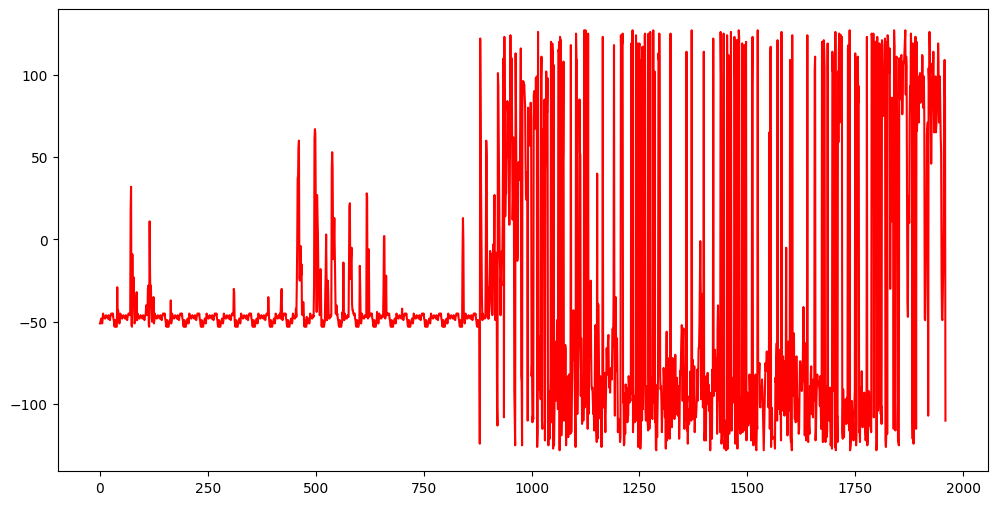

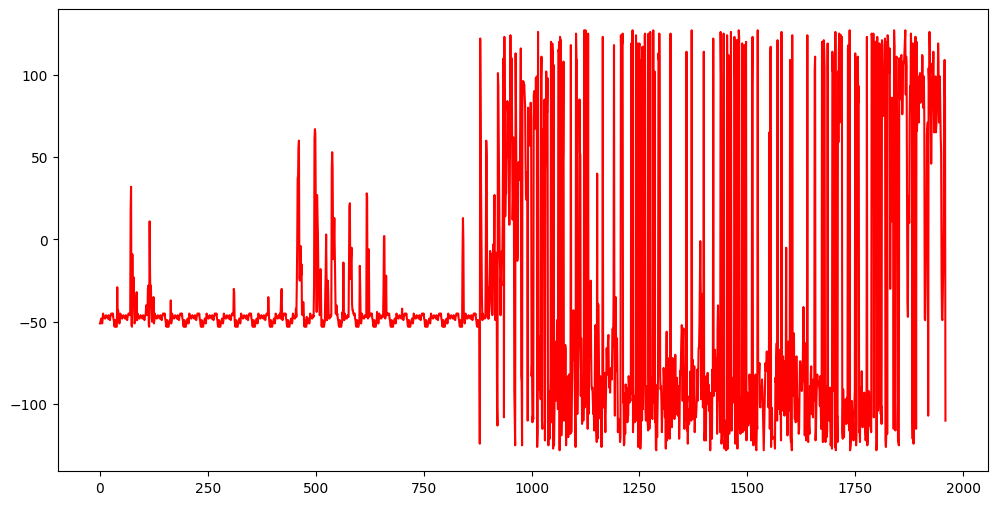

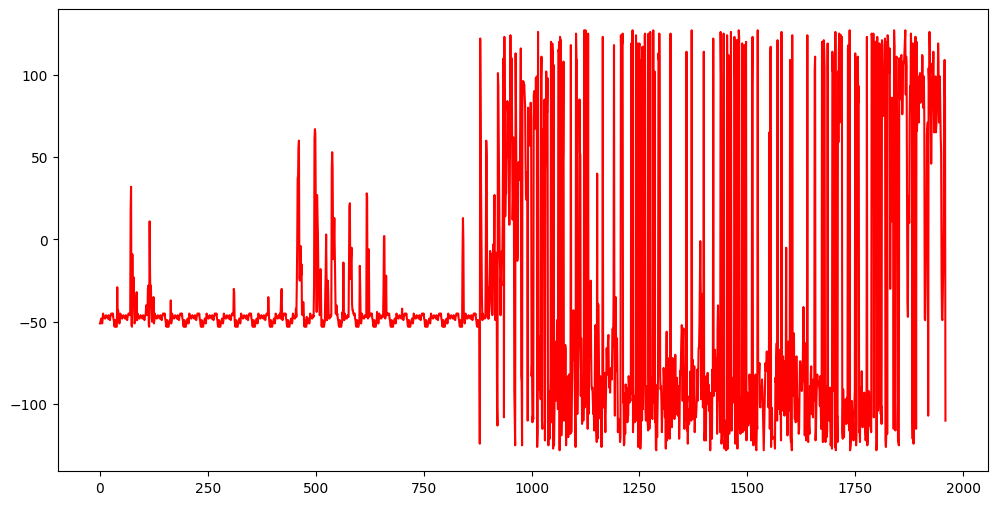

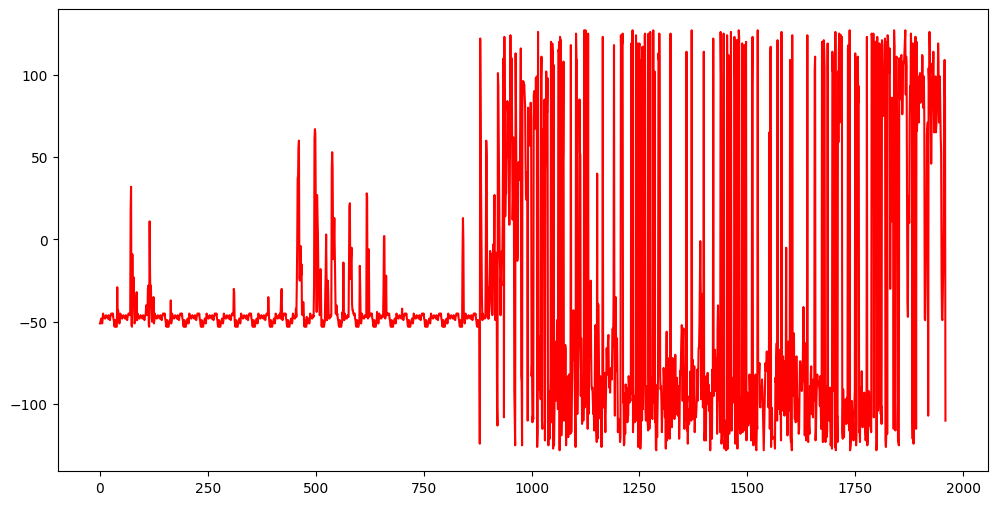

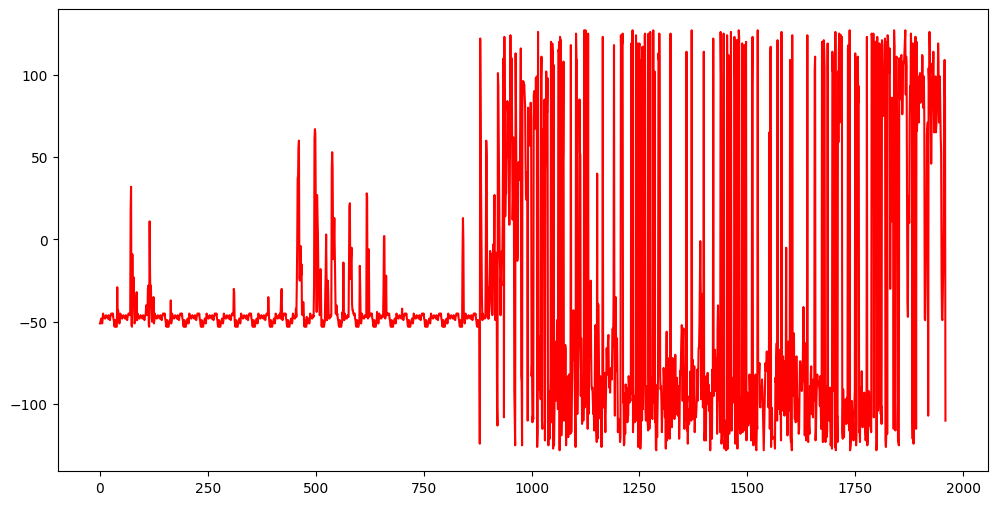

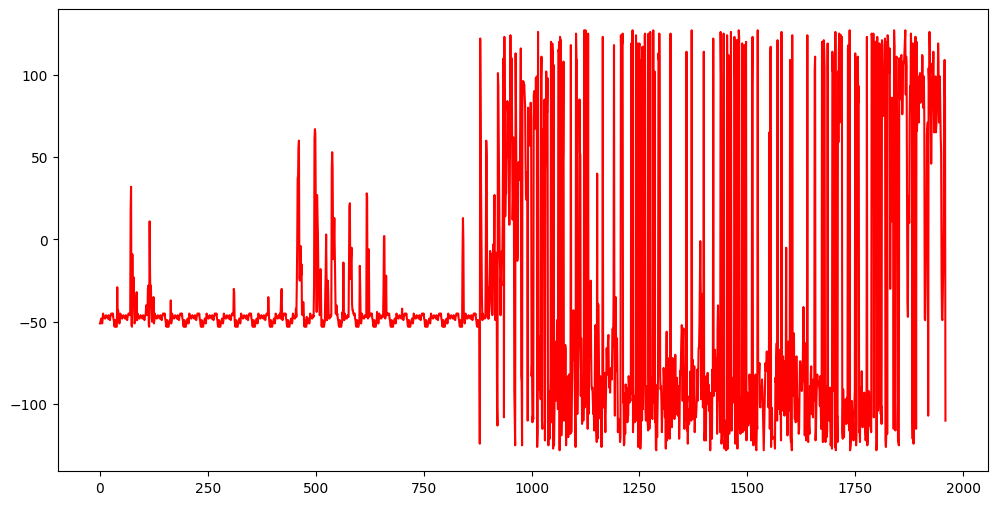

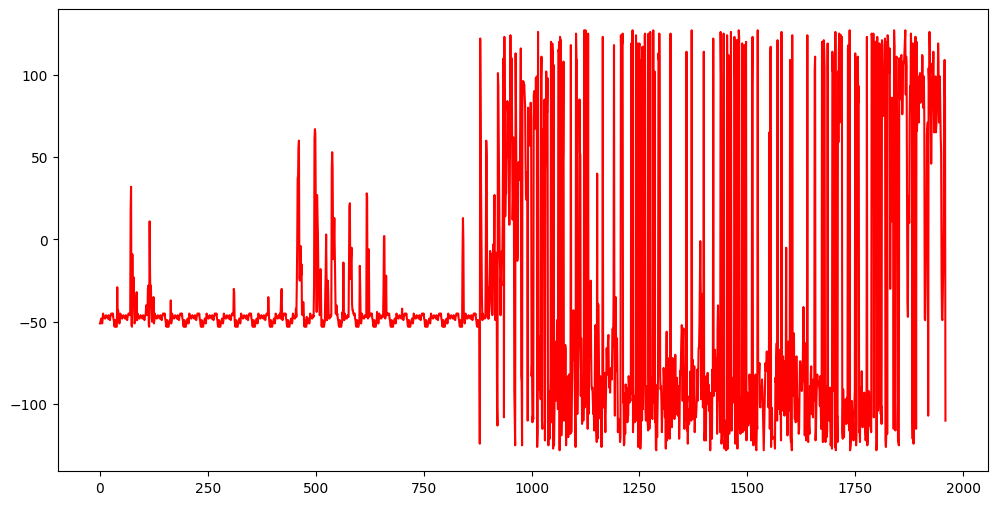

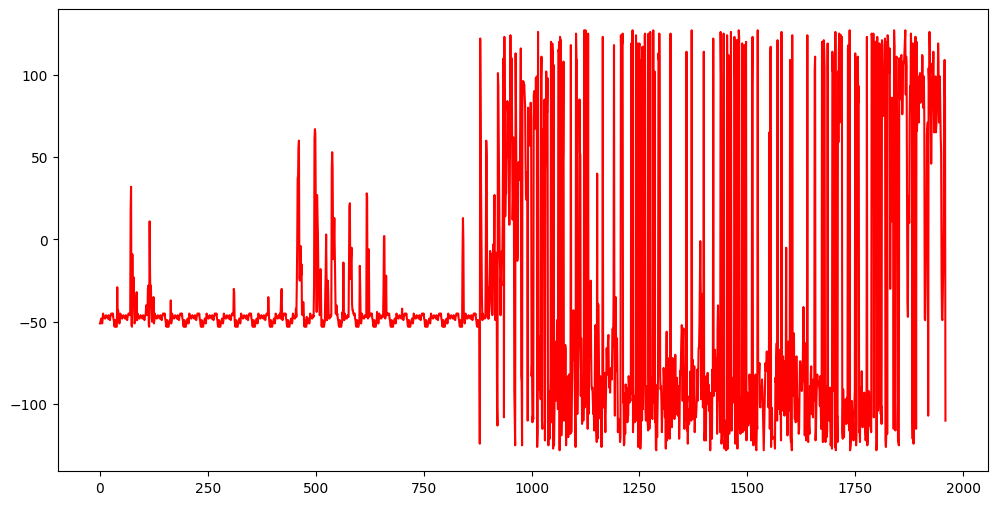

In [62]:
# Then test the model -- do they all work as you'd expect?
print("Testing yes1")
run_tflite_inference_singleFile(MODEL_TFLITE, yes1, sr_yes1, model_type="Quantized")
print("Testing yes2")
run_tflite_inference_singleFile(MODEL_TFLITE, yes2, sr_yes2, model_type="Quantized")
print("Testing yes3")
run_tflite_inference_singleFile(MODEL_TFLITE, yes3, sr_yes3, model_type="Quantized")
print("Testing yes4")
run_tflite_inference_singleFile(MODEL_TFLITE, yes4, sr_yes4, model_type="Quantized")
print("Testing no1")
run_tflite_inference_singleFile(MODEL_TFLITE, no1, sr_no1, model_type="Quantized")
print("Testing no2")
run_tflite_inference_singleFile(MODEL_TFLITE, no2, sr_no2, model_type="Quantized")
print("Testing no3")
run_tflite_inference_singleFile(MODEL_TFLITE, no3, sr_no3, model_type="Quantized")
print("Testing no4")
run_tflite_inference_singleFile(MODEL_TFLITE, no4, sr_no4, model_type="Quantized")






# Processing yes1 with sample rate 48000 Hz...
# Feature Shape: (1, 1960)
# Feature Mean: -16.8066
# Feature Min: -128.0000
# Feature Max: 127.0000
# Feature Range: -1.0000
# Generated features for yes1.

# Testing the model with your own data!

### Define the audio importing function
Adapted from: https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/ and https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=RtMcXr3o6gxN

In [27]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    bitsPerSecond: 128000, //chrome seems to ignore, always 48k
    audioBitsPerSecond: 128000, //chrome seems to ignore, always 48k
    mimeType : 'audio/mp4'
    // mimeType : 'audio/webm;codecs=opus' // try me if the above fails
  };
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav', ac='1')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr
print("Chrome Audio Recorder Defined")

Chrome Audio Recorder Defined


### Record your own audio and test the model!
After you run the record cell wait for the stop button to appear then start recording and then press the button to stop the recording once you have said the word!

In [28]:
custom_audio, sr_custom_audio = get_audio()
print("DONE")

IndexError: list index out of range

In [29]:
# Then test the model
run_tflite_inference_singleFile(MODEL_TFLITE, custom_audio, sr_custom_audio, model_type="Quantized")

NameError: name 'custom_audio' is not defined

In [89]:
import numpy as np
import scipy.signal as signal

def hann_window(window_size):
    """Generate Hann window weights."""
    return 0.5 * (1 - np.cos(2 * np.pi * np.arange(window_size) / (window_size - 1)))

def hz_to_mel(hz):
    """Convert frequency from Hz to Mel scale."""
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    """Convert frequency from Mel scale to Hz."""
    return 700 * (10 ** (mel / 2595) - 1)

def create_filter_bank(freqs, num_channels, lower_band_limit, upper_band_limit):
    """Create triangular filter bank."""
    # Mel scale limits
    mel_lower = hz_to_mel(lower_band_limit)
    mel_upper = hz_to_mel(upper_band_limit)

    # Mel scale points
    mel_points = np.linspace(mel_lower, mel_upper, num_channels + 2)
    hz_points = mel_to_hz(mel_points)

    # Filter bank matrix
    filter_bank = np.zeros((num_channels, len(freqs)))
    for i in range(1, num_channels + 1):
        left = hz_points[i - 1]
        center = hz_points[i]
        right = hz_points[i + 1]

        for j, f in enumerate(freqs):
            if left < f < center:
                filter_bank[i - 1, j] = (f - left) / (center - left)
            elif center <= f < right:
                filter_bank[i - 1, j] = (right - f) / (right - center)

    return filter_bank

def generate_feature(audio_signal, sample_rate, window_size_ms=30, stride_ms=20, num_channels=40, lower_band_limit=125, upper_band_limit=7500):
    """
    Generate features from an audio signal.

    Args:
        audio_signal (np.ndarray): 1D array of audio data.
        sample_rate (int): Sampling rate of the audio signal.
        window_size_ms (int): Duration of each window in milliseconds.
        stride_ms (int): Stride between consecutive windows in milliseconds.
        num_channels (int): Number of filter bank channels.
        lower_band_limit (float): Lower frequency band limit in Hz.
        upper_band_limit (float): Upper frequency band limit in Hz.

    Returns:
        np.ndarray: Features extracted from the audio signal.
    """
    # Convert window size and stride from ms to samples
    window_size = int(sample_rate * window_size_ms / 1000)
    print(f"Window size: {window_size}")
    stride_size = int(sample_rate * stride_ms / 1000)
    print(f"Stride size: {stride_size}")

    # Hann window
    hann_weights = hann_window(window_size)

    # Calculate number of frames
    num_frames = (len(audio_signal) - window_size) // stride_size + 1

    # FFT size (next power of 2 for efficiency)
    fft_size = 2 ** int(np.ceil(np.log2(window_size)))

    # Frequency range for filter bank
    freqs = np.linspace(0, sample_rate / 2, fft_size // 2 + 1)
    filter_bank = create_filter_bank(freqs, num_channels, lower_band_limit, upper_band_limit)

    features = []

    # Process each frame
    for i in range(num_frames):
        # Extract frame
        start = i * stride_size
        end = start + window_size
        frame = audio_signal[start:end]

        # Apply Hann window
        windowed_frame = frame * hann_weights

        # Compute FFT
        fft_output = np.fft.rfft(windowed_frame, n=fft_size)

        # Calculate energy
        energy = np.abs(fft_output) ** 2

        # Apply filter bank
        filter_bank_energy = np.dot(filter_bank, energy[:fft_size // 2 + 1])

        # Log scale (add small constant to avoid log(0))
        log_features = np.log(filter_bank_energy + 1e-6)

        features.append(log_features)

    features = np.array(features)

    # Apply Noise Reduction: Spectral Subtraction (simple example)
    noise_estimation = np.mean(features, axis=0)
    features = np.maximum(features - noise_estimation, 0)

    # Apply Gain Control (example using PCA normalization)
    pca_mean = np.mean(features, axis=0)
    pca_std = np.std(features, axis=0)
    features = (features - pca_mean) / (pca_std + 1e-6)

    # Scale down the tensor data using log (already done above) and convert to int8
    features = np.int8(features * 255 / np.max(np.abs(features)))  # Rescale to fit int8 range

    print(features.shape)

    # features = features.reshape(1, target_length)

    # Print statistics and shape
    print(f"Feature Shape: {features.shape}")
    print(f"Feature Mean: {np.mean(features):.4f}")
    print(f"Feature Min: {np.min(features):.4f}")
    print(f"Feature Max: {np.max(features):.4f}")
    print(f"Feature Range: {np.max(features) - np.min(features):.4f}")

    return features

# Example usage with loaded audio files
if __name__ == "__main__":
    import pickle

    # Load the pickle file containing audio data
    with open('yes_no.pkl', 'rb') as fid:
        audio_files = pickle.load(fid)

    # Process each audio file
    for key in ["yes1", "yes2", "yes3", "yes4", "no1", "no2", "no3", "no4"]:
        audio_signal = audio_files[key]
        sample_rate = audio_files[f"sr_{key}"]

        print(f"Processing {key} with sample rate {sample_rate} Hz...")
        features = generate_feature(audio_signal, sample_rate=48000)
        print(f"Generated features for {key}.\n")


Processing yes1 with sample rate 48000 Hz...
Window size: 480
Stride size: 320
(242, 40)
Feature Shape: (242, 40)
Feature Mean: -18.0744
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000
Generated features for yes1.

Processing yes2 with sample rate 48000 Hz...
Window size: 480
Stride size: 320
(395, 40)
Feature Shape: (395, 40)
Feature Mean: -2.4501
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000
Generated features for yes2.

Processing yes3 with sample rate 48000 Hz...
Window size: 480
Stride size: 320
(251, 40)
Feature Shape: (251, 40)
Feature Mean: -1.4627
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000
Generated features for yes3.

Processing yes4 with sample rate 48000 Hz...
Window size: 480
Stride size: 320
(377, 40)
Feature Shape: (377, 40)
Feature Mean: -6.5814
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000
Generated features for yes4.

Processing no1 with sample rate 48000 Hz...
Window size: 480
St

<ipython-input-89-451286fef8e7>:125: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")


Processing yes1 with sample rate 48000 Hz...
(80, 40)
Feature Shape: (80, 40)
Feature Mean: -28.4403
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000


<ipython-input-86-cc1105d07d3b>:140: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")


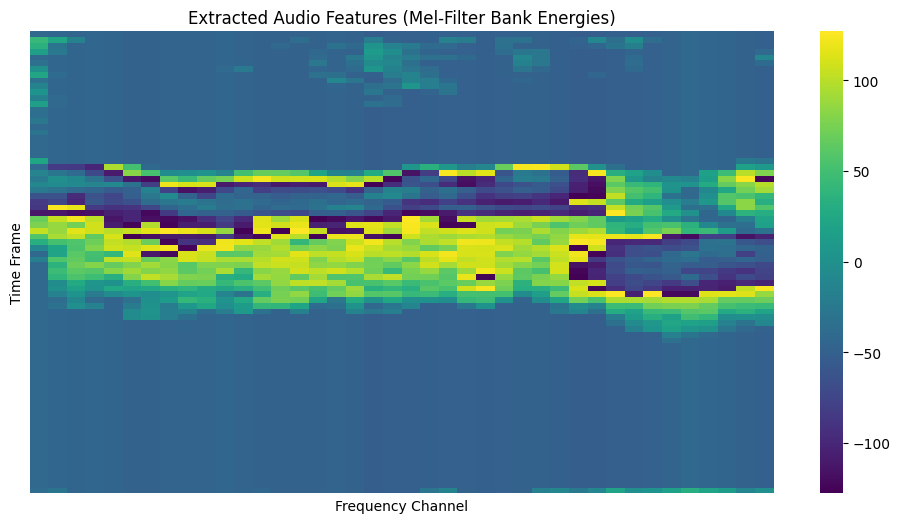

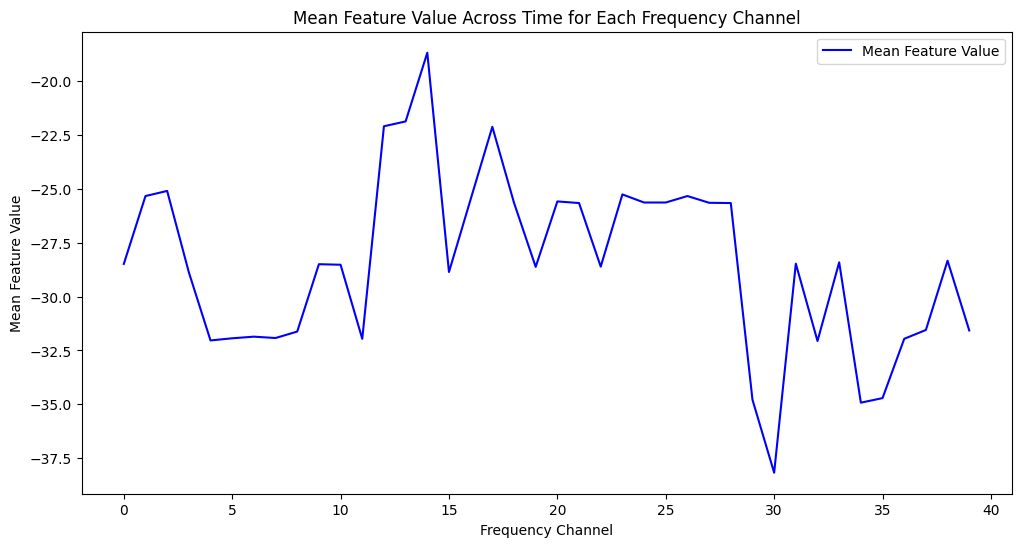

Processing yes2 with sample rate 48000 Hz...
(131, 40)
Feature Shape: (131, 40)
Feature Mean: -20.6061
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000


<ipython-input-86-cc1105d07d3b>:140: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")


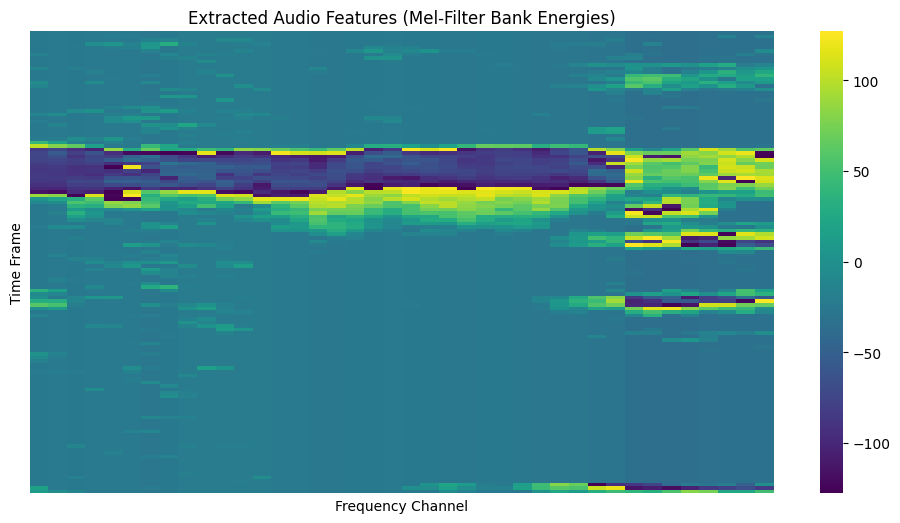

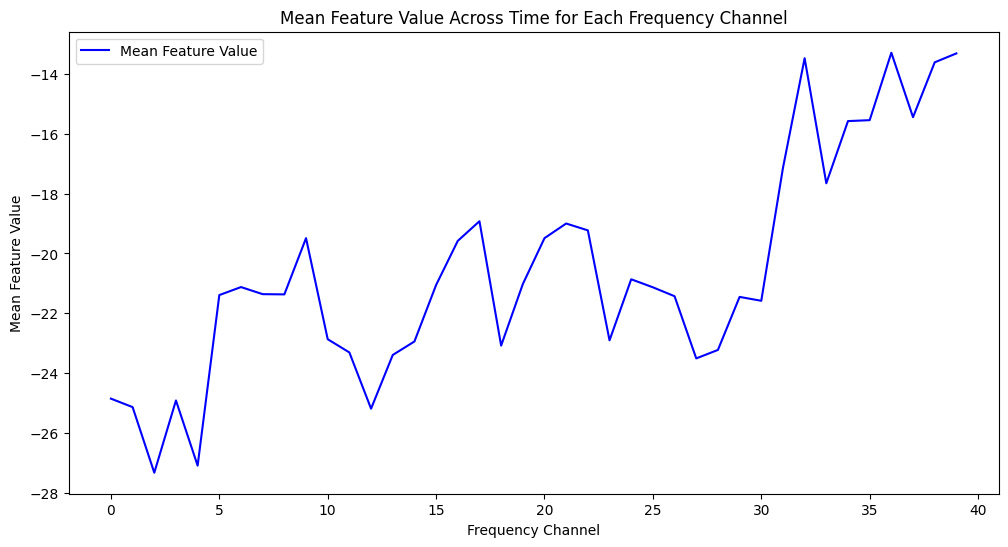

Processing yes3 with sample rate 48000 Hz...
(83, 40)
Feature Shape: (83, 40)
Feature Mean: -27.3033
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000


<ipython-input-86-cc1105d07d3b>:140: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")


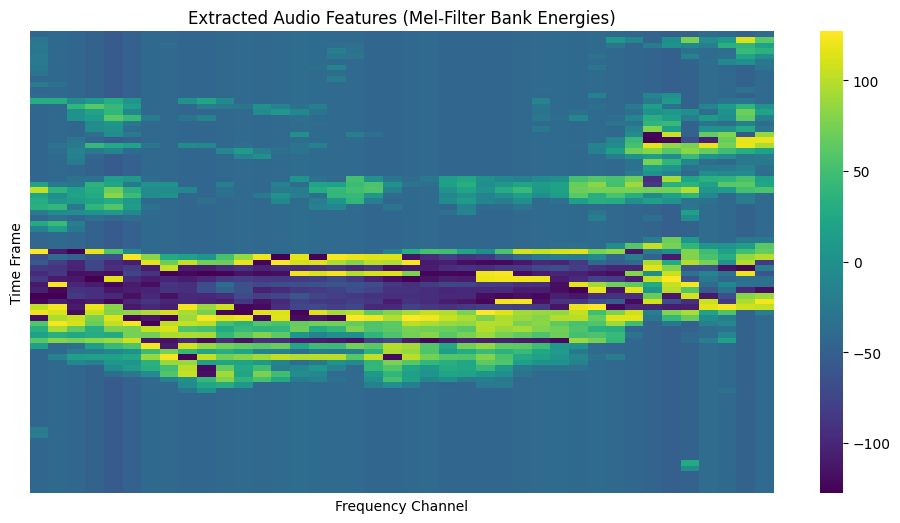

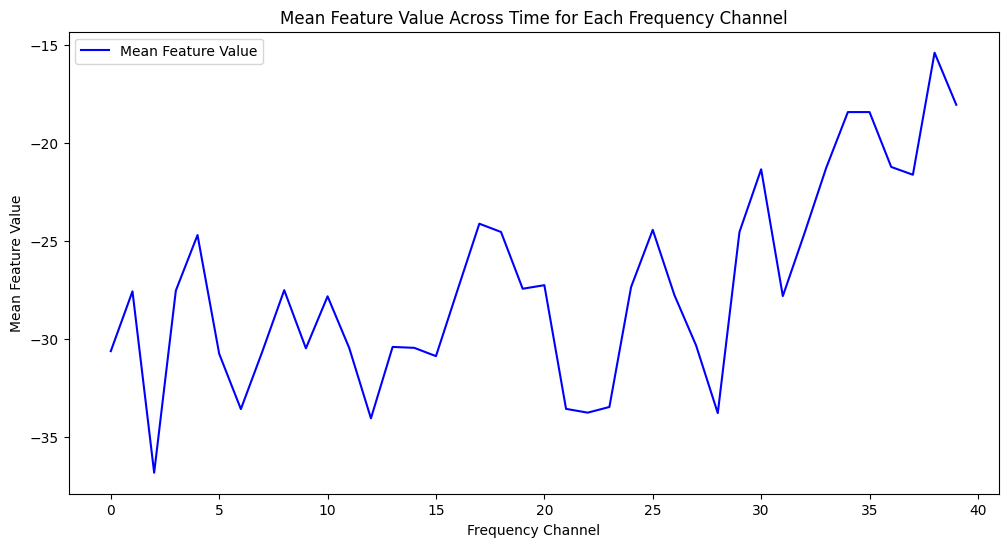

Processing yes4 with sample rate 48000 Hz...
(125, 40)
Feature Shape: (125, 40)
Feature Mean: -23.7448
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000


<ipython-input-86-cc1105d07d3b>:140: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")


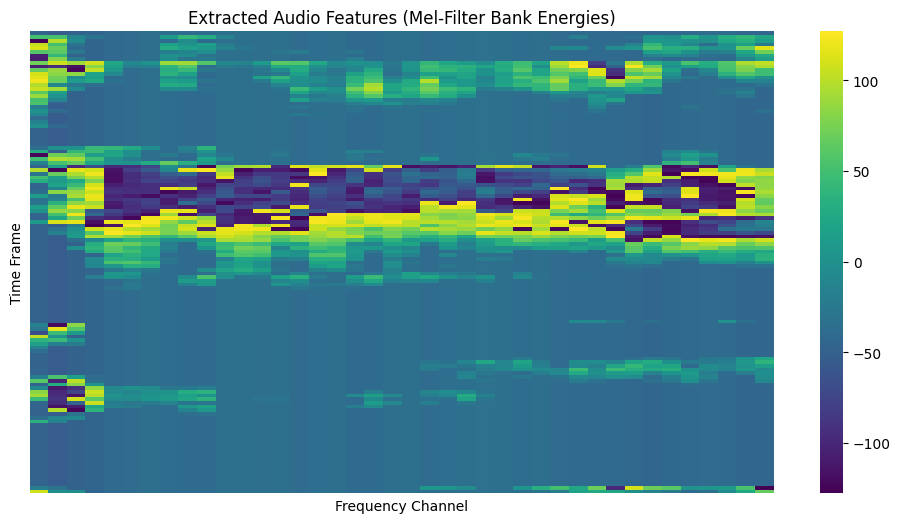

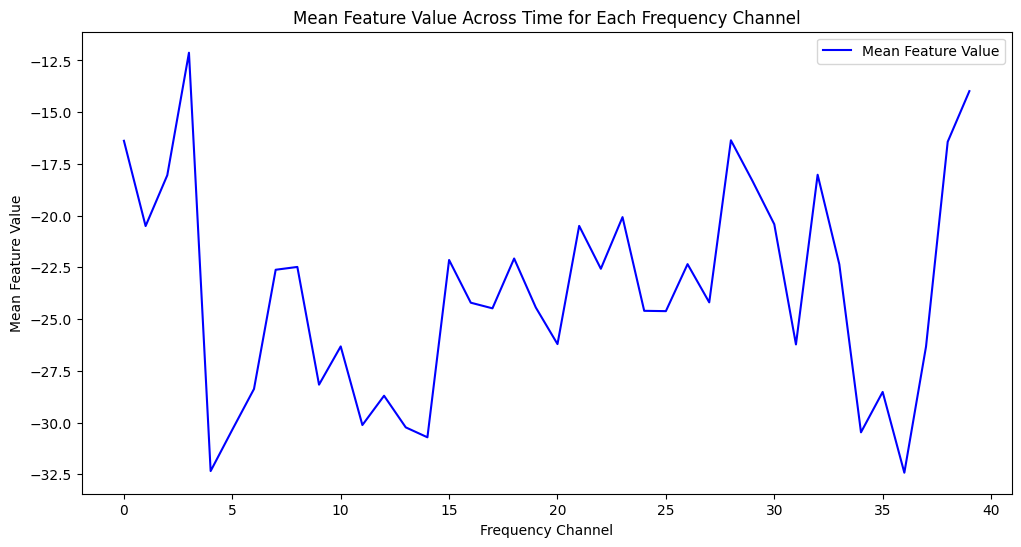

Processing no1 with sample rate 48000 Hz...
(80, 40)
Feature Shape: (80, 40)
Feature Mean: -10.6622
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000


<ipython-input-86-cc1105d07d3b>:140: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")


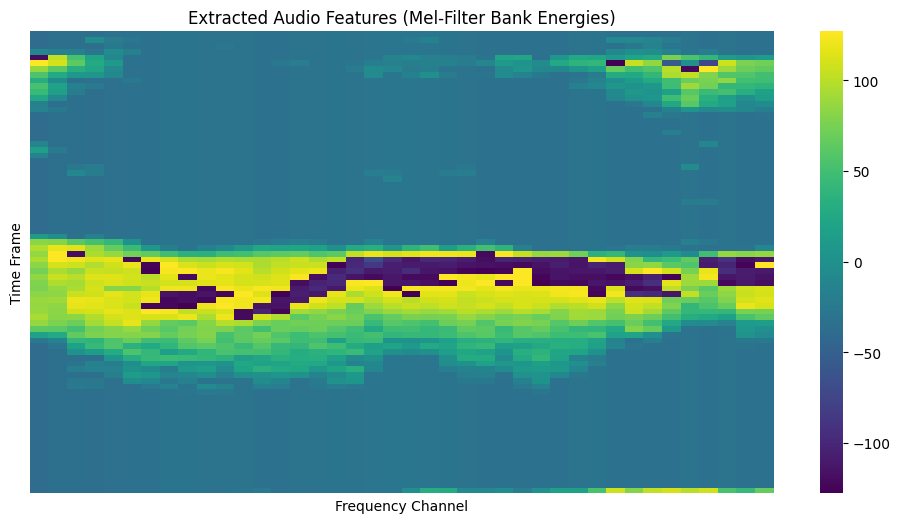

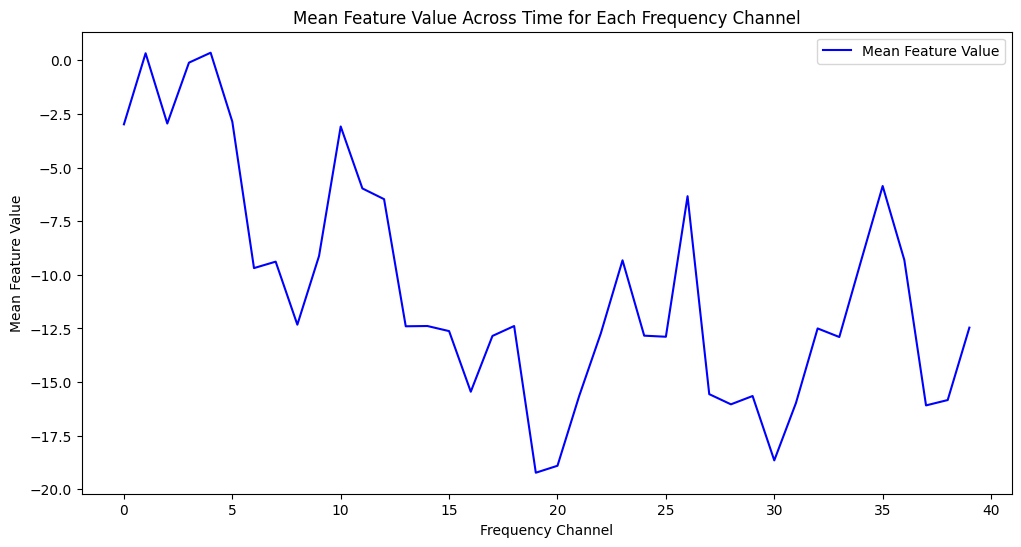

Processing no2 with sample rate 48000 Hz...
(98, 40)
Feature Shape: (98, 40)
Feature Mean: -5.4140
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000


<ipython-input-86-cc1105d07d3b>:140: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")


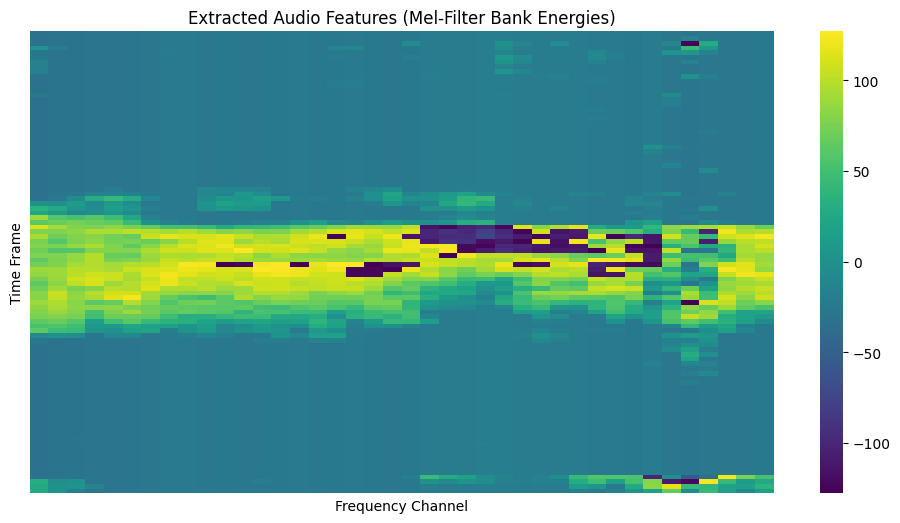

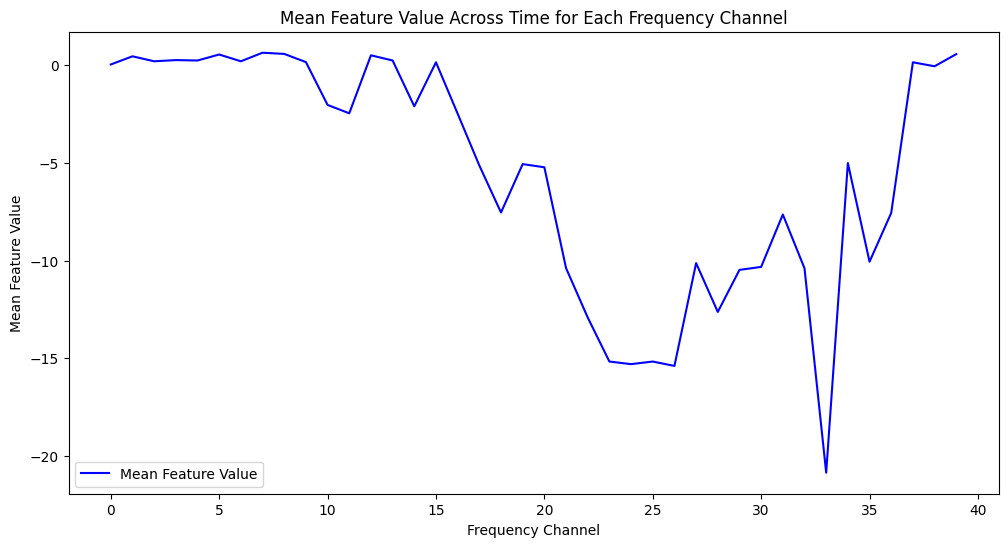

Processing no3 with sample rate 48000 Hz...
(92, 40)
Feature Shape: (92, 40)
Feature Mean: -37.1310
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000


<ipython-input-86-cc1105d07d3b>:140: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")


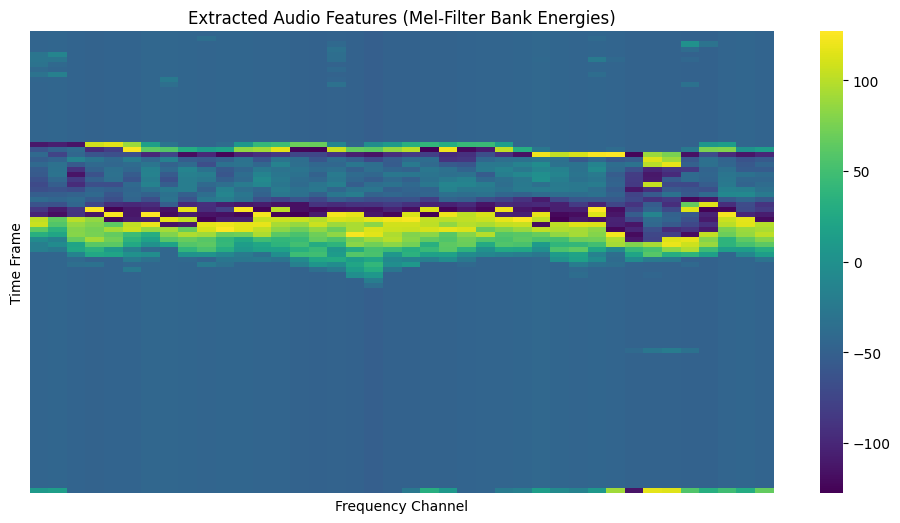

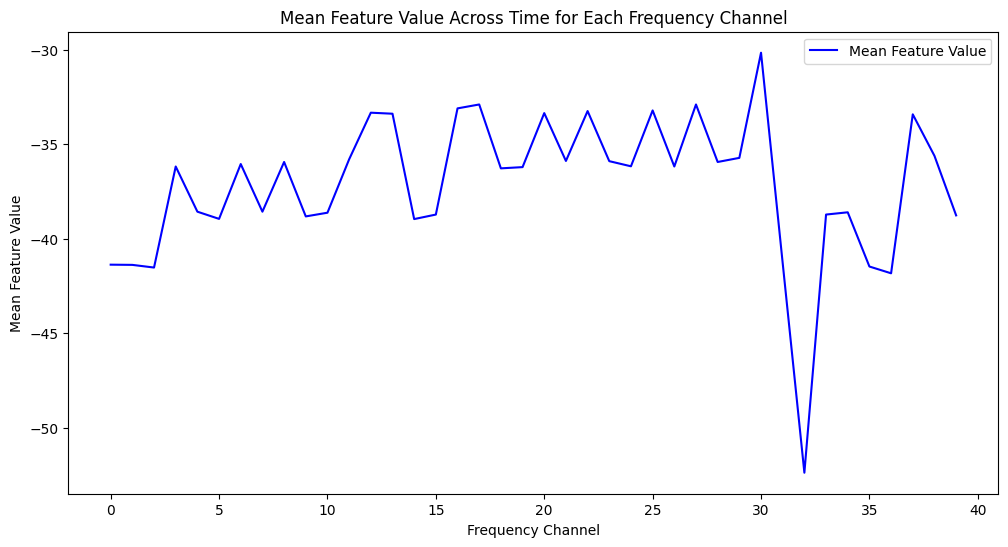

Processing no4 with sample rate 48000 Hz...
(119, 40)
Feature Shape: (119, 40)
Feature Mean: -37.6926
Feature Min: -128.0000
Feature Max: 127.0000
Feature Range: -1.0000


<ipython-input-86-cc1105d07d3b>:140: RuntimeWarning: overflow encountered in scalar subtract
  print(f"Feature Range: {np.max(features) - np.min(features):.4f}")


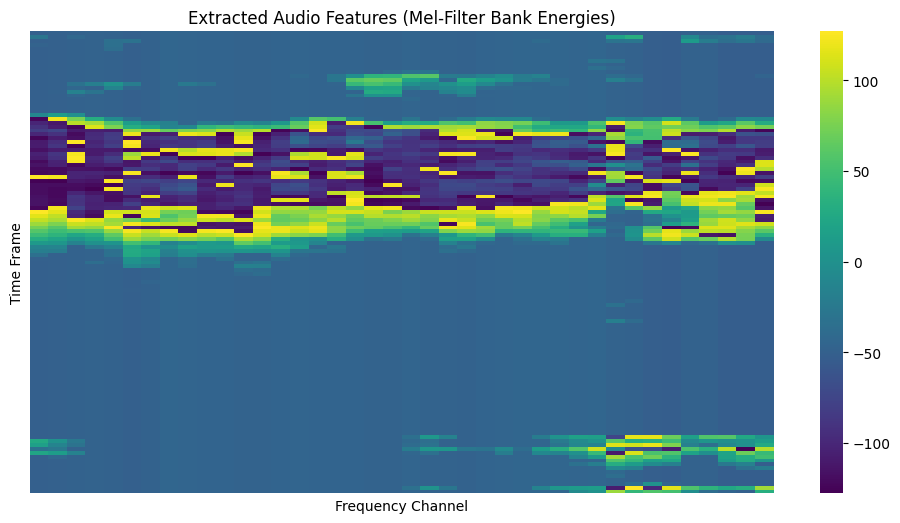

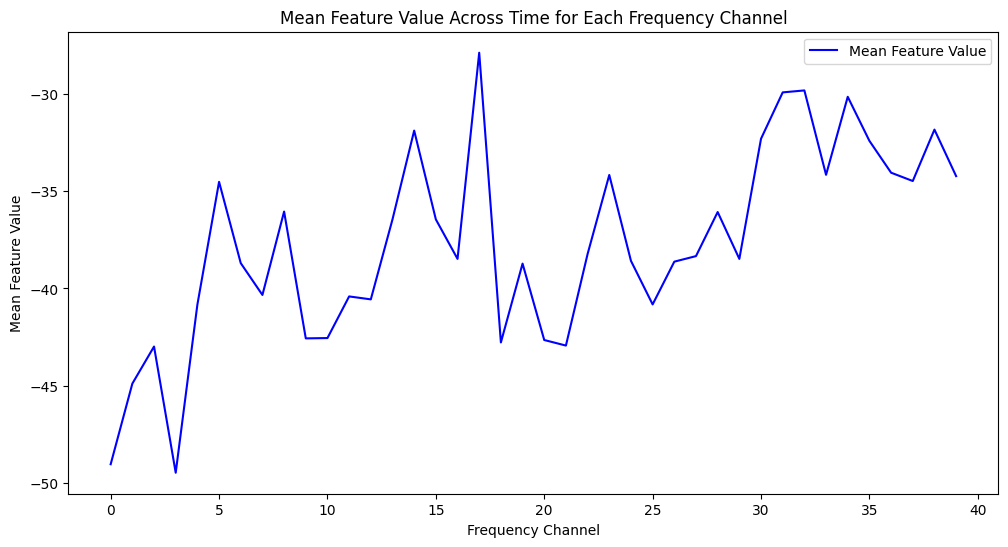

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_features(features):
    """
    Plot the extracted features as a heatmap.

    Args:
        features (np.ndarray): Feature matrix with shape (num_frames, num_channels).
    """
    plt.figure(figsize=(12, 6))

    # Plot the heatmap
    sns.heatmap(features, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)

    # Set the labels and title
    plt.xlabel("Frequency Channel")
    plt.ylabel("Time Frame")
    plt.title("Extracted Audio Features (Mel-Filter Bank Energies)")

    plt.show()

def plot_feature_mean(features):
    """
    Plot the mean of features across time frames for each frequency channel.

    Args:
        features (np.ndarray): Feature matrix with shape (num_frames, num_channels).
    """
    mean_features = np.mean(features, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(mean_features, label="Mean Feature Value", color='blue')

    plt.xlabel("Frequency Channel")
    plt.ylabel("Mean Feature Value")
    plt.title("Mean Feature Value Across Time for Each Frequency Channel")
    plt.legend()

    plt.show()

# Example usage with features generated from audio
if __name__ == "__main__":
    import pickle

    # Load the pickle file containing audio data
    with open('yes_no.pkl', 'rb') as fid:
        audio_files = pickle.load(fid)

    # Process each audio file and plot features
    for key in ["yes1", "yes2", "yes3", "yes4", "no1", "no2", "no3", "no4"]:
        audio_signal = audio_files[key]
        sample_rate = audio_files[f"sr_{key}"]

        print(f"Processing {key} with sample rate {sample_rate} Hz...")
        features = generate_feature(audio_signal, sample_rate=48000)

        # Plot features
        plot_features(features)
        plot_feature_mean(features)


In [94]:
import numpy as np

def hann_window(window_size):
    """Generate Hann window weights."""
    return 0.5 * (1 - np.cos(2 * np.pi * np.arange(window_size) / (window_size - 1)))

def generate_feature(audio_signal, sample_rate=16000, window_size_ms=30, stride_ms=20, num_channels=40, lower_band_limit=125, upper_band_limit=7500):
    """
    Generate features from an audio signal.

    Args:
        audio_signal (np.ndarray): 1D array of 16-bit signed PCM audio data.
        sample_rate (int): Sampling rate of the audio signal (default: 16KHz).
        window_size_ms (int): Duration of each window in milliseconds.
        stride_ms (int): Stride between consecutive windows in milliseconds.
        num_channels (int): Number of filter bank channels.
        lower_band_limit (float): Lower frequency band limit in Hz.
        upper_band_limit (float): Upper frequency band limit in Hz.

    Returns:
        np.ndarray: Features extracted from the audio signal.
    """
    # Convert window size and stride from ms to samples
    window_size = int(sample_rate * window_size_ms / 1000)
    print(f"Window size: {window_size}")
    stride_size = int(sample_rate * stride_ms / 1000)
    print(f"Stride size: {stride_size}")

    # Hann window
    hann_weights = hann_window(window_size)

    # Calculate number of frames
    num_frames = (len(audio_signal) - window_size) // stride_size + 1

    print(f"Number of frames: {num_frames}")

    # FFT size (next power of 2 for efficiency)
    fft_size = 2 ** int(np.ceil(np.log2(window_size)))

    # Frequency range for filter bank
    freqs = np.linspace(0, sample_rate / 2, fft_size // 2 + 1)
    filter_bank = create_filter_bank(freqs, num_channels, lower_band_limit, upper_band_limit)

    features = []

    # Process each frame
    for i in range(num_frames):
        # Extract frame
        start = i * stride_size
        end = start + window_size
        frame = audio_signal[start:end]

        # Apply Hann window
        windowed_frame = frame * hann_weights

        # Compute FFT
        fft_output = np.fft.rfft(windowed_frame, n=fft_size)

        # Calculate energy
        energy = np.abs(fft_output) ** 2

        # Apply filter bank
        filter_bank_energy = np.dot(filter_bank, energy[:fft_size // 2 + 1])

        # Log scale (add small constant to avoid log(0))
        log_features = np.log(filter_bank_energy + 1e-6)

        features.append(log_features)

    return np.array(features)

def create_filter_bank(freqs, num_channels, lower_band_limit, upper_band_limit):
    """Create triangular filter bank."""
    # Mel scale limits
    mel_lower = hz_to_mel(lower_band_limit)
    mel_upper = hz_to_mel(upper_band_limit)

    # Mel scale points
    mel_points = np.linspace(mel_lower, mel_upper, num_channels + 2)
    hz_points = mel_to_hz(mel_points)

    # Filter bank matrix
    filter_bank = np.zeros((num_channels, len(freqs)))
    for i in range(1, num_channels + 1):
        left = hz_points[i - 1]
        center = hz_points[i]
        right = hz_points[i + 1]

        for j, f in enumerate(freqs):
            if left < f < center:
                filter_bank[i - 1, j] = (f - left) / (center - left)
            elif center <= f < right:
                filter_bank[i - 1, j] = (right - f) / (right - center)

    return filter_bank

def hz_to_mel(hz):
    """Convert frequency from Hz to Mel scale."""
    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):
    """Convert frequency from Mel scale to Hz."""
    return 700 * (10 ** (mel / 2595) - 1)

# Example usage:
if __name__ == "__main__":
    # Generate a synthetic sine wave as audio input
    duration = 1.0  # 1 second
    sample_rate = 48000
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    sine_wave = (np.sin(2 * np.pi * 440 * t) * 32767).astype(np.int16)  # 440 Hz tone
    print("Sine wave shape:", sine_wave.shape)
    print()
    audio_data = yes1
    print("Audio data shape:", audio_data.shape)
    audio_data = yes1  # Your input audio data
    audio_resampled = librosa.resample(librosa.to_mono(np.float64(audio_data)), orig_sr=48000, target_sr=SAMPLE_RATE)
    print("Resampled audio shape:", audio_resampled.shape)

    features = generate_feature(sine_wave, sample_rate = 48000)
    print("Generated features shape:", features.shape)


Sine wave shape: (48000,)

Audio data shape: (77760,)
Resampled audio shape: (25920,)
Window size: 1440
Stride size: 960
Number of frames: 49
Generated features shape: (49, 40)
